# 23MAR23 In Class Exercise
Module: Population Differntiation & Demography \
Topic: Introgression.

In [1]:
# Import modules.
import demes
import demesdraw
import numpy as np
import stdpopsim
from scipy.stats import norm
import msprime
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Print versions.
print('demes', demes.__version__)
print('demesdraw', demesdraw.__version__)
print('msprime', msprime.__version__)
print('numpy', np.__version__)

demes 0.2.2
demesdraw 0.3.1
msprime 1.2.0
numpy 1.23.5


First, let's write a function to define a demographic model that matches the IUA model of introgression we went over in class with the following paramters from:

- $T_{P3} = 15,000$ generations ago
- $T_{P2} = 5,000$ generations ago
- $T_{GF} = 1,000$ generations ago
- $N = 10,000$

In [2]:
# Define IUA model of introgression.
def iua(f):
    # Intialize demographic model.
    iua_model = msprime.Demography()
    # We assume constant and equal effective population sizes for
    # all lineages.
    iua_model.add_population(name='P1', initial_size=10_000)
    iua_model.add_population(name='P2', initial_size=10_000)
    iua_model.add_population(name='P3', initial_size=10_000)
    iua_model.add_population(name='P12', initial_size=10_000)
    iua_model.add_population(name='P123', initial_size=10_000)
    # Introgression from P3 -> P2 1,000 generations ago with
    # a probability of f.
    iua_model.add_mass_migration(
        time=1_000, source='P2', dest='P3', proportion=f,
    )
    # P1 and P2 merge into the ancestral population P12
    # 5,000 generations ago.
    iua_model.add_population_split(
        time=5_000, derived=['P1', 'P2'], ancestral='P12',
    )
    # P12 and P3 merge into the ancestral population P123
    # 15,000 generations ago.
    iua_model.add_population_split(
        time=15_000, derived=['P12', 'P3'], ancestral='P123',
    )
    return iua_model

Great, now let's visualize the model!

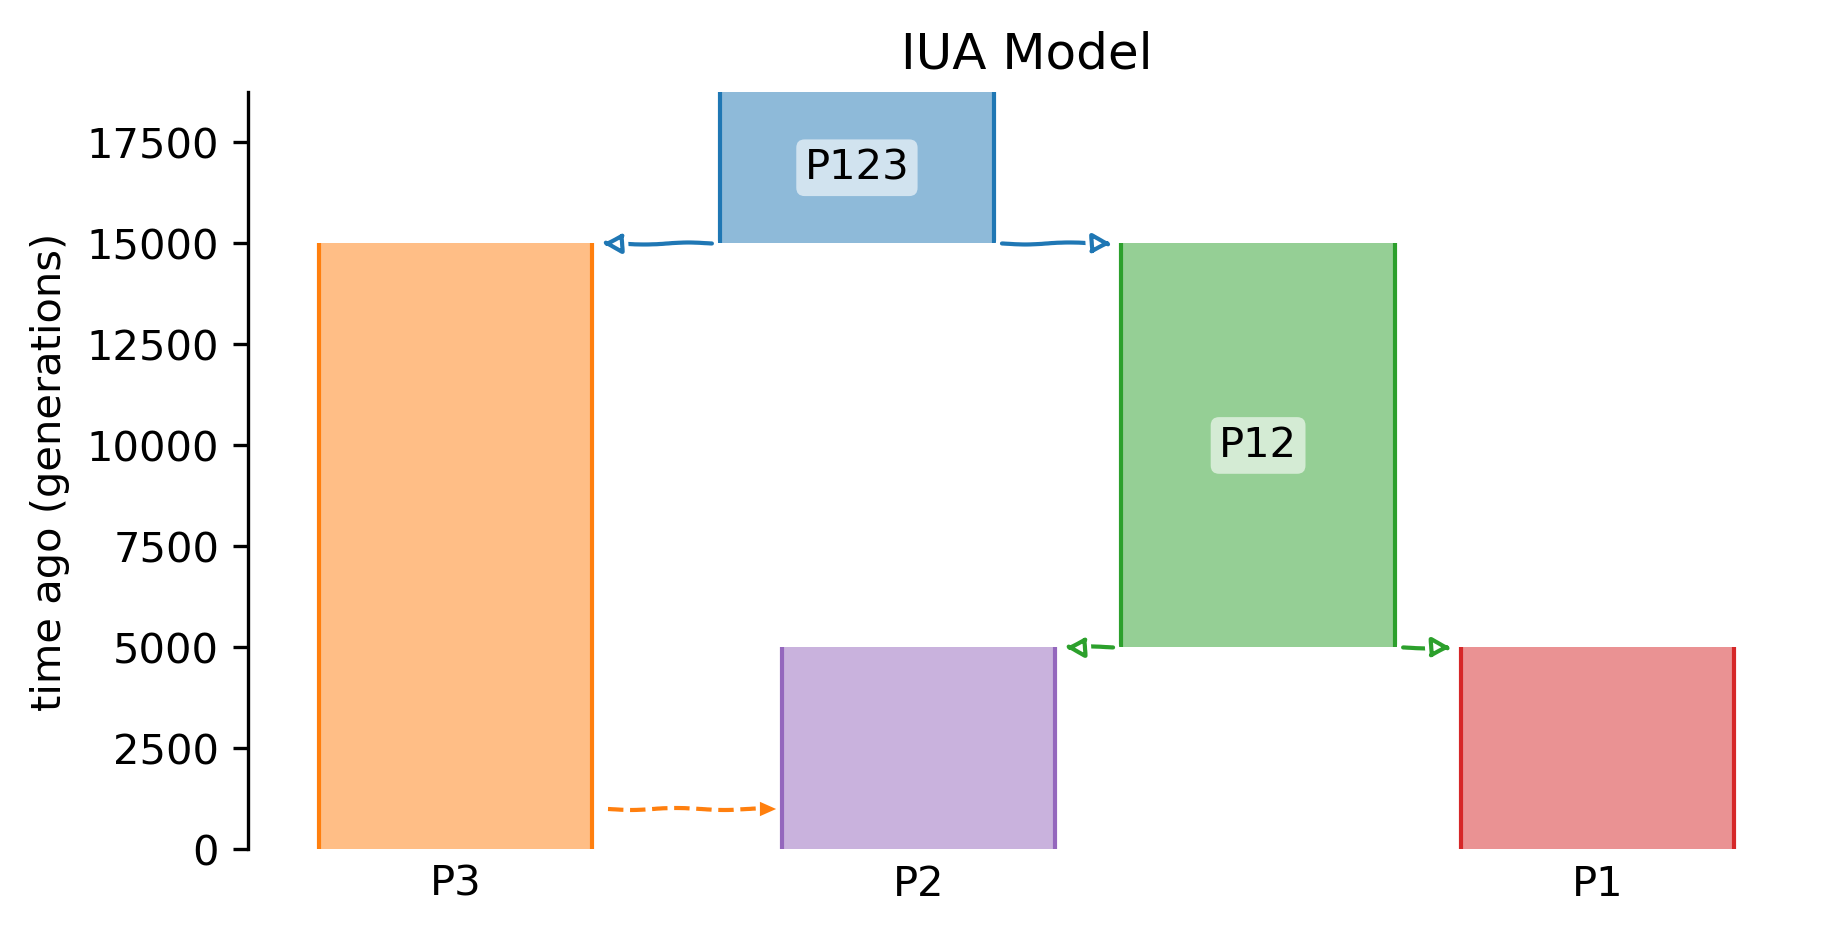

In [3]:
# Intialize a model with an introgression prbability of 0.1 .
iua_f01_demo = iua(0.1)
# Convert the demographic object to a demes graph.
iua_f01_graph = msprime.Demography.to_demes(iua_f01_demo)
# Intialize the figure.
fig = plt.figure(
    figsize=(6, 3),
    constrained_layout=True,
    dpi=300.0,
)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the demes graph.
demesdraw.tubes(
    iua_f01_graph,
    ax=ax,
    title='IUA Model',
    seed=42,
)
# Show the plot.
plt.show()

Great, everything looks like it should. To review, in the code above we have created a function that takes an admixture proportion as input (ie $f$), and returns a demographic object for `msprime` that mirrors the IUA model we have been using to derive the $ABBA$ and $BABA$ site patterns from lecture. Next, we Intialized an IUA model with an admixture proportion of 0.1 (ie $f=0.1$), and then visualized the demographic object using `demes` and `demesdraw`. Now, let's define functions to compute the number of $ABBA$ and $BABA$ sites as well as Patterson's D. Before executing each cell make sure you understand what the code does, and if you don't please ask your instructor!

In [4]:
# Define derived allele frequency function.
def derived_allele_freq(
    genotype_matrix,
    taxon,
):
    """
    ###########################################################################
    INPUT
        genotype_matrix: Simulated genotypes from msprime.
        taxon: Lineage to calculate the derived allele frequencies for.
    ---------------------------------------------------------------------------
    OUTPUT: Derived allele frequency array for the lineage of interest.
    ---------------------------------------------------------------------------
    NOTE: This function will return counts when the sample size is 1.
    ###########################################################################
    """
    # Calculate derived allele frequencies.
    freq_array = genotype_matrix[:, taxon].sum(axis=1)/float(len(taxon))
    return freq_array

In [5]:
# Define a function to calculate site patterns.
def site_patterns(
    genotype_matrix,
    p1_idx,
    p2_idx,
    p3_idx,
):
    """
    ###########################################################################
    INPUT
        p1: Derived alle frequency array for the P1 lineage.
        p2: Derived alle frequency array for the P2 lineage.
        p3: Derived alle frequency array for the P3 lineage.
    ---------------------------------------------------------------------------
    OUTPUT: Genome counts of ABBA and BABA.
    ###########################################################################
    """
    # Calculate derived allele frequencies per taxa.
    p1 = derived_allele_freq(genotype_matrix, p1_idx)
    p2 = derived_allele_freq(genotype_matrix, p2_idx)
    p3 = derived_allele_freq(genotype_matrix, p3_idx)
    # Calculate site pattern counts.
    abba = ((1 - p1) * (p2) * (p3)).sum()
    baba = ((p1) * (1 - p2) * (p3)).sum()
    return abba, baba

In [6]:
# Define a function to calculate Patterson's D.
def pattersons_d(
    genotype_matrix,
    p1_idx,
    p2_idx,
    p3_idx
):
    """
    ###########################################################################
    INPUT: Genome-wide ABBA, BABA, BAAA, and ABAA counts from frequencies.
    ---------------------------------------------------------------------------
    OUTPUT: Patterson's D, Danc, and D+ values.
    ###########################################################################
    """
    # Calculate site pattern counts.
    abba, baba = site_patterns(genotype_matrix, p1_idx, p2_idx, p3_idx)
    # If abba + baba = 0...
    if (abba + baba) == 0:
        # Set to np.nan.
        d = np.nan
    # Else...
    else:
        # Calculate Patterson's D.
        d = ((abba - baba) / (abba + baba))
    return abba, baba, d

Awesome! So now that we have defined all our functions, let's run a simulation using the IUA model with an admixture proportion of $f=0.1$.

In [29]:
# Simulate a 1 Mb tree-sequence.
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, ploidy=1, population='P1'),
        msprime.SampleSet(1, ploidy=1, population='P2'),
        msprime.SampleSet(1, ploidy=1, population='P3'),
        ],
    demography=iua(0.1), # f = 0.1 .
    sequence_length=1_000_000,
    recombination_rate=10**-8,
    random_seed=42,
)
# Overlay mutations on the tree-sequence.
mts = msprime.sim_mutations(
    tree_sequence=ts,
    rate=1.5 * 10**-8,
    random_seed=42,
    discrete_genome=False,
)
# View the tree-sequence report.
mts

Now, to calculate Patterson's D in empirical data we would need to also consider an outgroup to poalrize ancestral states in our genotype matrix, however `msprime` keeps tracks of ancestral states under the hood so that is not necessary in simulations! Now, let's extract the genotype matrix from the simulation and calculate the number of $ABBA$ and $BABA$ sites, but before you run the code in the cell below think about if you would expect to see more $ABBA$ and $BABA$ sites and why!

In [30]:
# Extract the genotype matrix.
geno_mat = mts.genotype_matrix()
# Determine the number of ABBA and BABA sites.
n_abba, n_baba = site_patterns(
    genotype_matrix=geno_mat,
    p1_idx=[0],
    p2_idx=[1],
    p3_idx=[2],
)
# Print a summary.
print(f'there are {n_abba} site and {n_baba} site')

there are 141.0 site and 63.0 site


So there are a little more than twice the number of $ABBA$ sites than $BABA$ sites, but does this make sense? Why or why not? Confer with your partner to see if they agree and if you don't understand please ask the instructor! Now, let's calaculate Patterson's D for this simulation, but before doing based on the number of $ABBA$ and $BABA$ do you expect we will have a positive or negative value? 

In [9]:
# Compute Patterson's D.
_, _, d_stat = pattersons_d(
    genotype_matrix=geno_mat,
    p1_idx=[0],
    p2_idx=[1],
    p3_idx=[2],
)
# Print a summary.
print(f'Patterson\'s D = {round(d_stat, 3)}')

Patterson's D = 0.382


Amazing, we have a positive Patterson's D value! What does this mean? Well, it is actually hard to inetrepret without assessing sigificance first! From lecture, we know that in the case of no introgression Patterson's D is expected to be zero, so let's simulate a thousand replicates using our IUA model without introgression (ie $f=0$).

In [10]:
# Intialize a list to store simulated replicates.
null_list = []
# For 1000 simulated replicates.
for rep in range (1, 1001):
    # Simulate a 1 Mb tree-sequence.
    ts = msprime.sim_ancestry(
        samples=[
            msprime.SampleSet(1, ploidy=1, population='P1'),
            msprime.SampleSet(1, ploidy=1, population='P2'),
            msprime.SampleSet(1, ploidy=1, population='P3'),
            ],
        demography=iua(0), # f = 0 .
        sequence_length=1_000_000,
        recombination_rate=10**-8,
        random_seed=rep,
    )
    # Overlay mutations on the tree-sequence.
    mts = msprime.sim_mutations(
        tree_sequence=ts,
        rate=1.5 * 10**-8,
        random_seed=rep,
        discrete_genome=False,
    )
    # Compute Patterson's D.
    _, _, d_val = pattersons_d(
        genotype_matrix=mts.genotype_matrix(),
        p1_idx=[0],
        p2_idx=[1],
        p3_idx=[2],
    )
    # Append the results.
    null_list.append(d_val)
# Convert the list to an array.
null_array = np.array(null_list)
# Run a sanity check to make sure you simulated 1000 replicates.
print(f'there are {null_array.size} simulated replicates')

there are 1000 simulated replicates


Awesome! We just simulated our null distribution, let's visualize it and think about how we can assess if our obseved Patterson's D value of 0.382 is statistically significant.

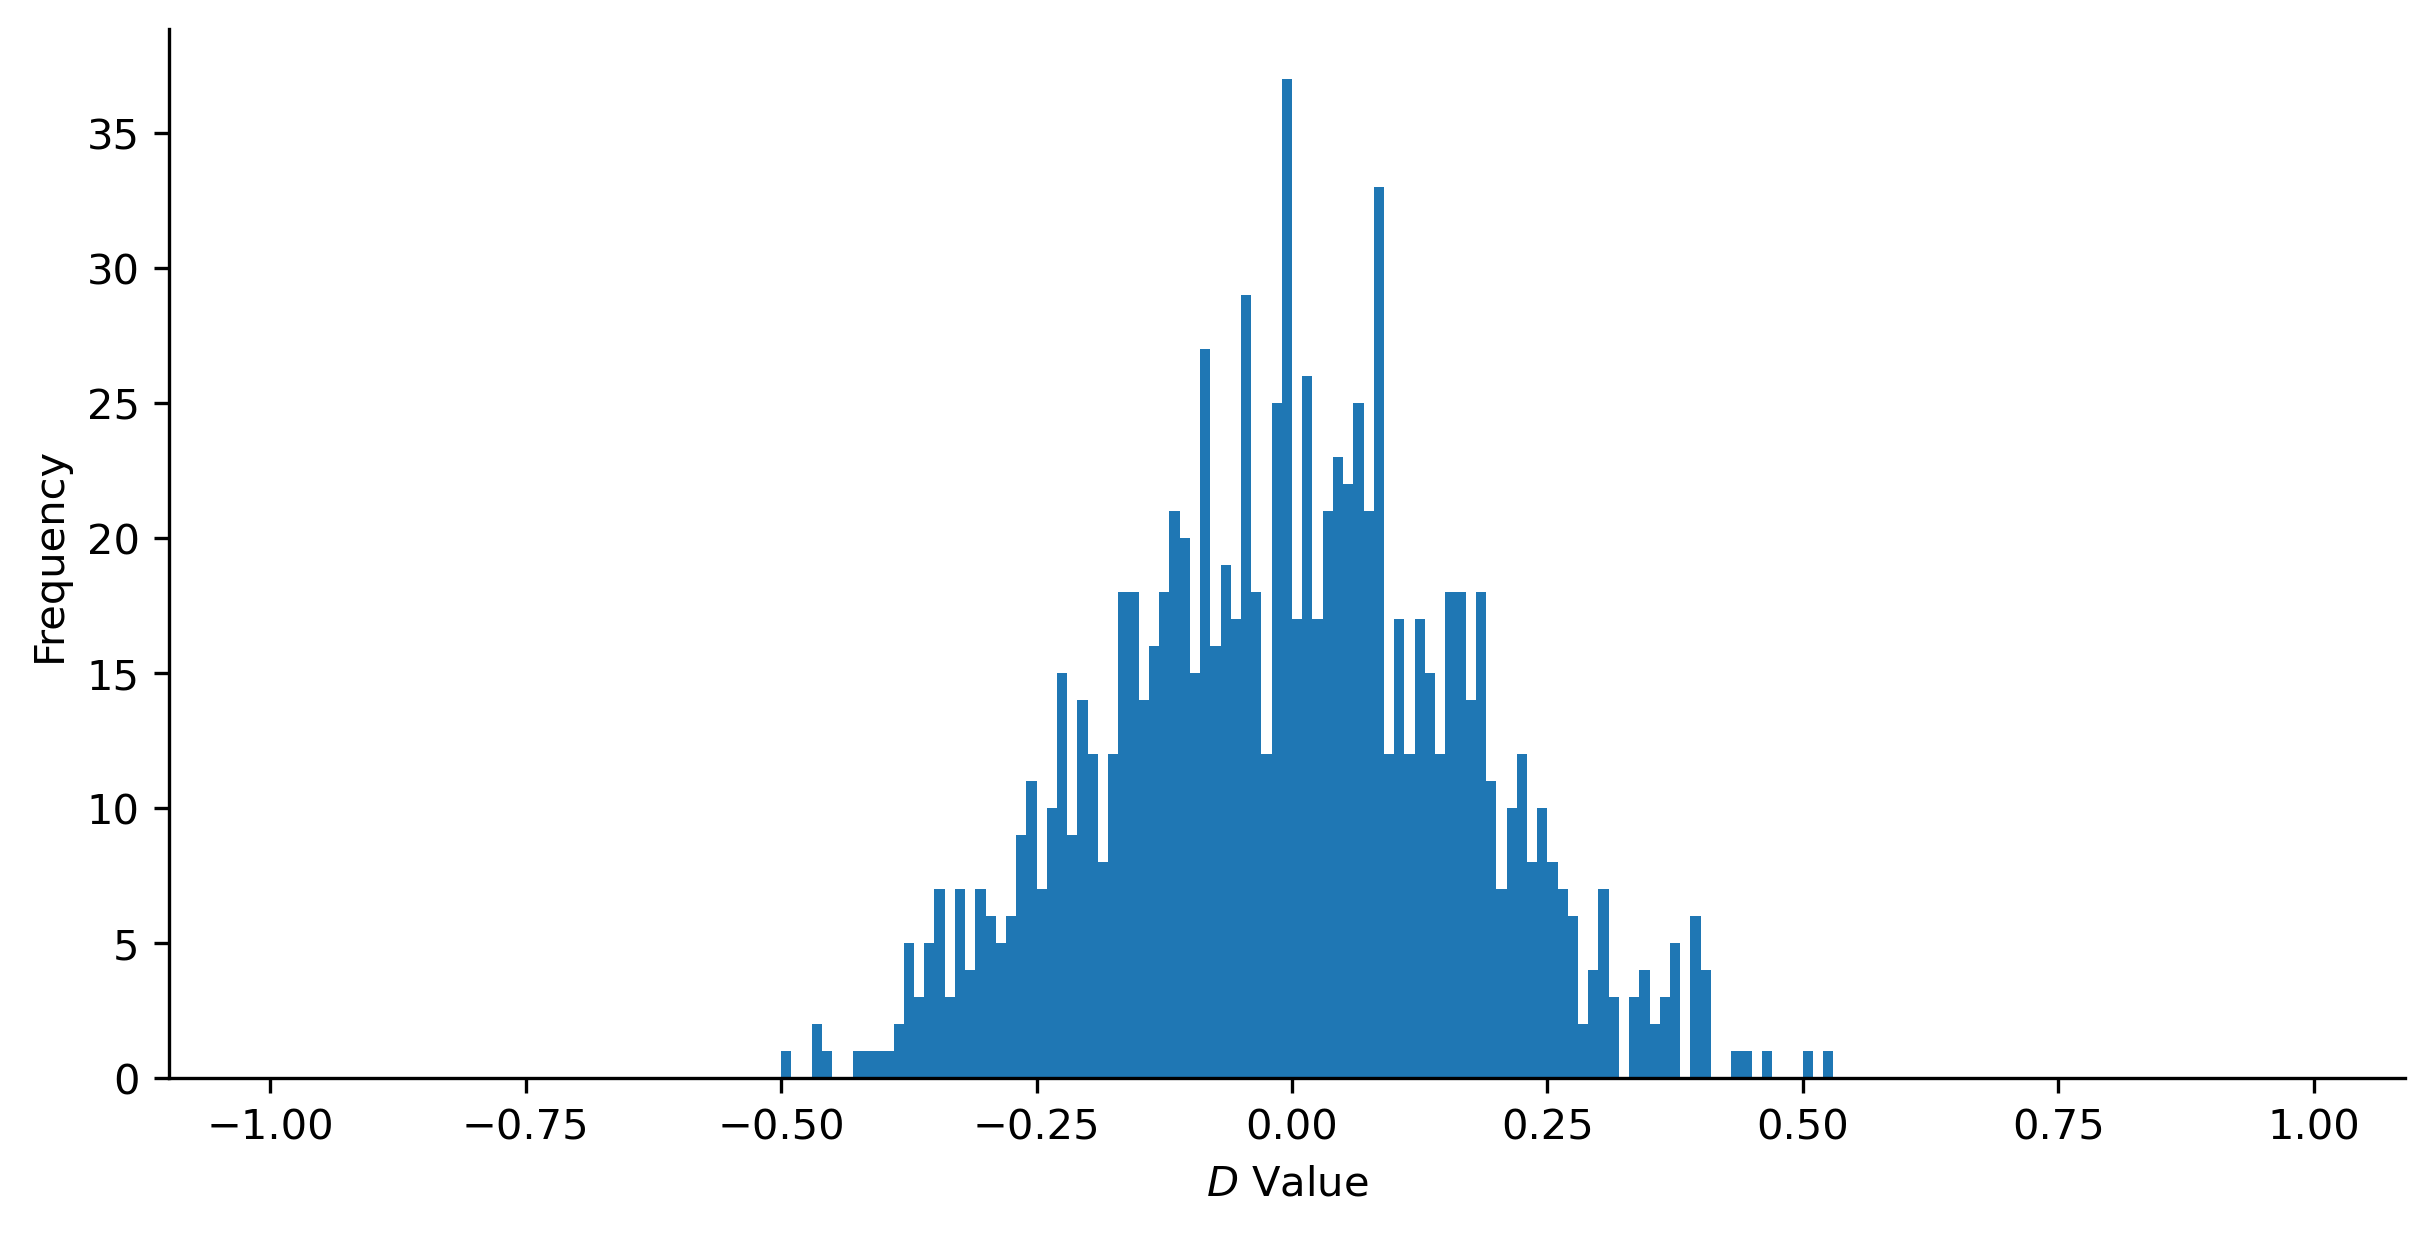

In [11]:
# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the null distribution.
ax.hist(
    null_array, bins=np.arange(-1, 1, 0.01),
    histtype='stepfilled',
    color='tab:blue',
)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Label the axes.
plt.xlabel(r'$D$ Value')
plt.ylabel('Frequency')
# Show!
plt.show()

So from the plot above we can see that the null distribution for Patterson's D is roughly normally distributed around zero. From lecture, we know that to interpret our observed Patterson's D value we need to assess if it is statistically different from zero. To do so we will use the survival function for the normal distribution—ie 1 - CDF—from the `scipy` library. Before running the code below, what would the interpretation be if the observed value was significant? Converse with your partner and if you are confused please ask your instructor!

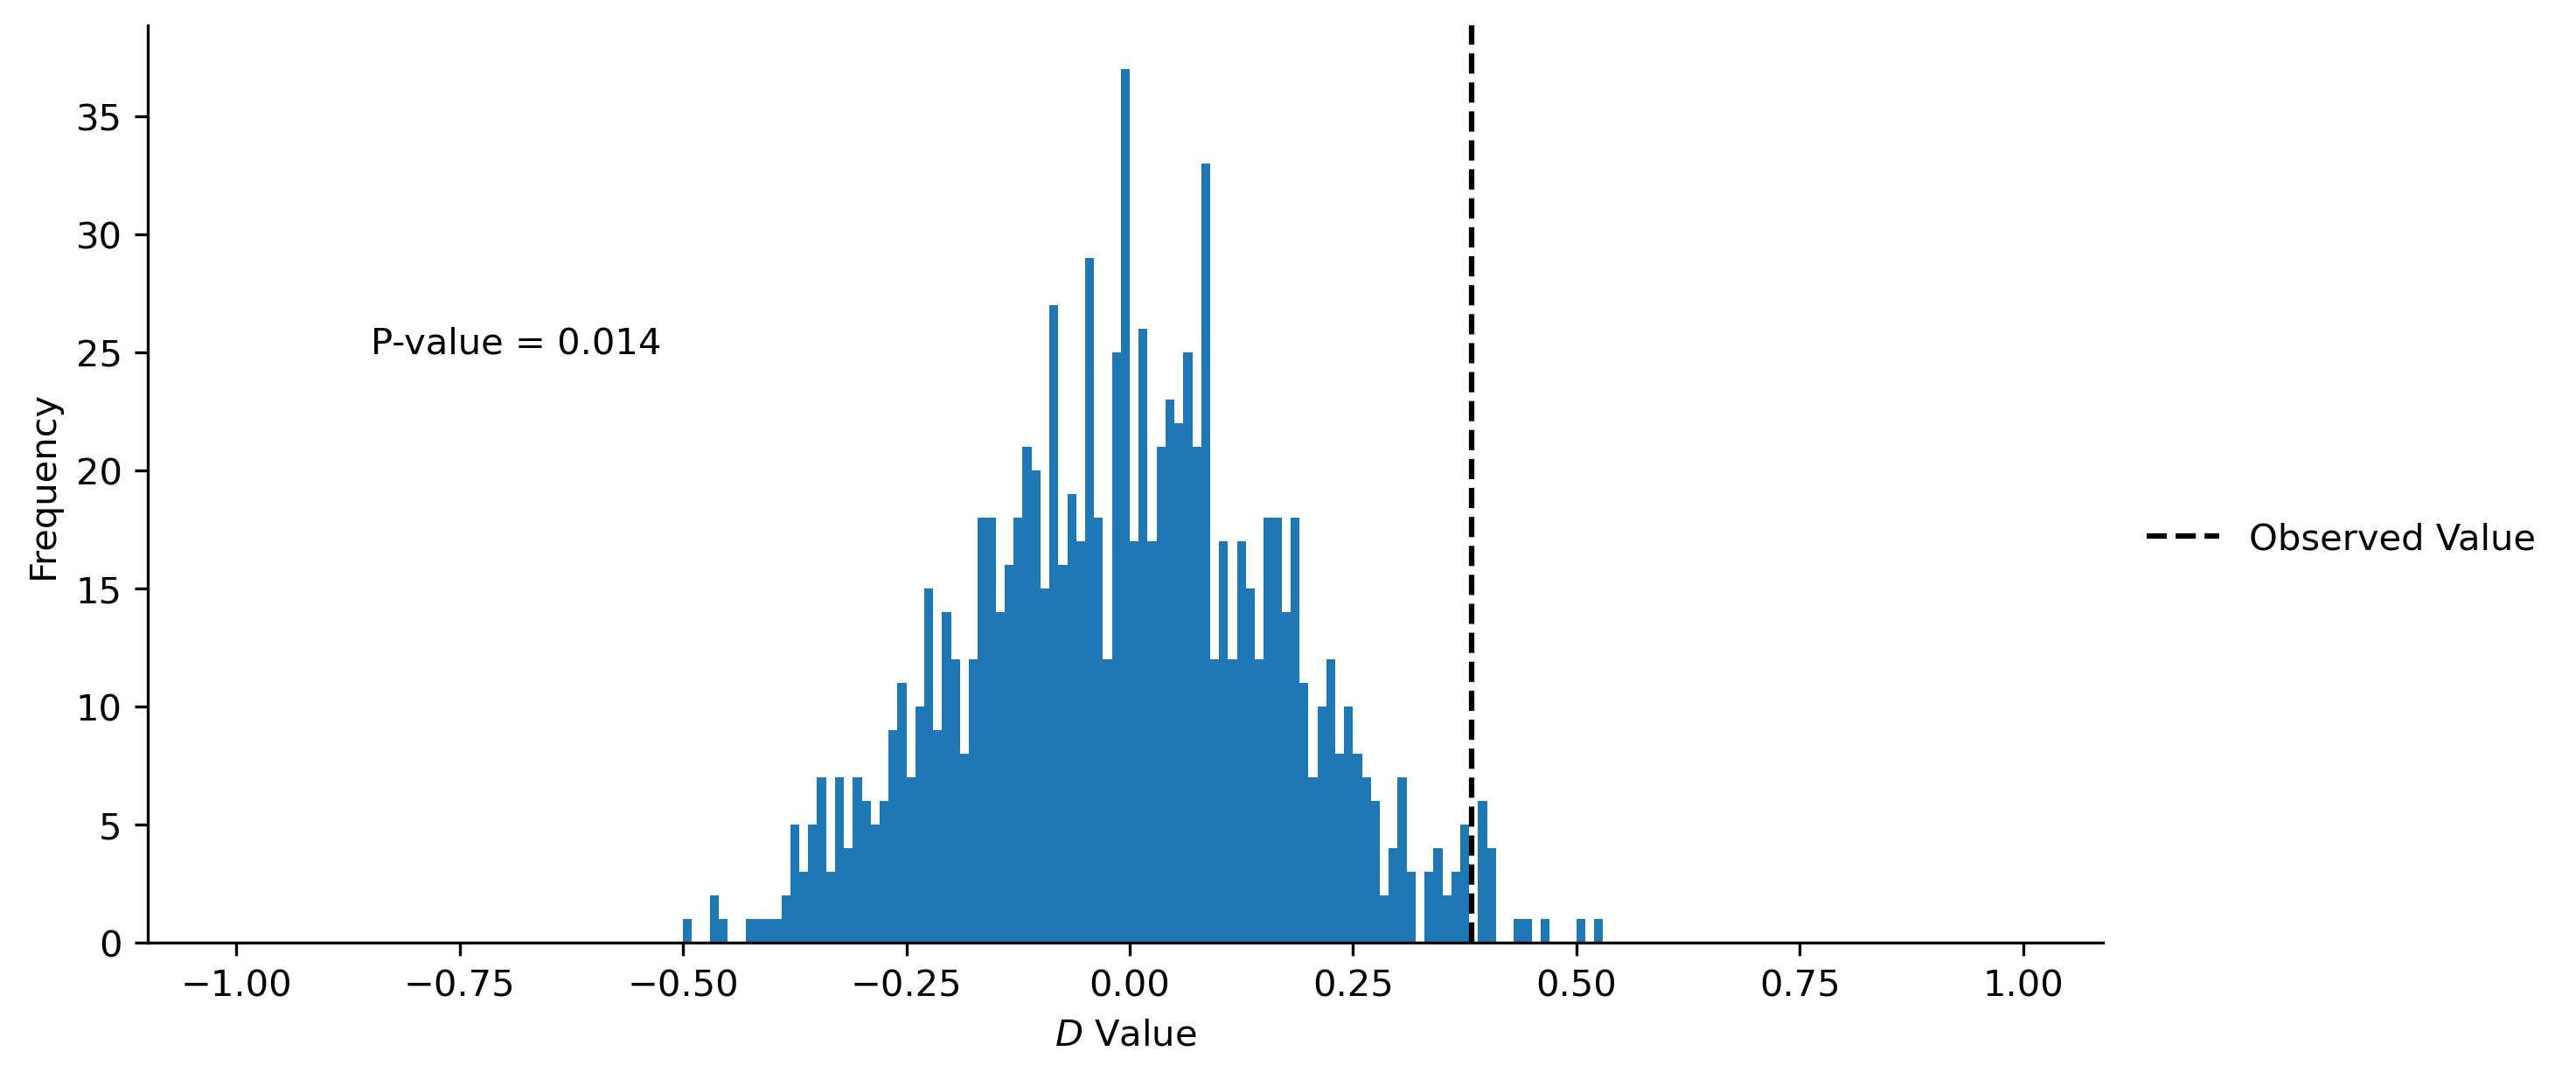

In [12]:
# Calculate the p-value from the bootstrapped distribution.
pval = norm.sf(x=abs(d_stat), loc=0, scale=np.nanstd(null_array))
# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the null distribution.
ax.hist(
    null_array, bins=np.arange(-1, 1, 0.01),
    histtype='stepfilled',
    color='tab:blue',
)
# Plot the observed value.
ax.axvline(
    d_stat, 0, 1, label='Observed Value',
    color='black', linestyle='dashed',
)
# Annotate the pvalue.
ax.text(
    -0.85, 25,
    f'P-value = {round(pval, 3)}',
)
# Add a figure legend.
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Label the axes.
plt.xlabel(r'$D$ Value')
plt.ylabel('Frequency')
# Show!
plt.show()

So using a naive significance threshold of 0.05 we would consider or observed Patterson's D value to be significantly different from zero! This can be intepreted as rejecting an ILS only model, suggesting that P2 and P3 share more derived alleles than expected by random chance. However, we have also learned from lecture that if there is introgression P2 and P3 should be genetically closer to one another than P1 and P3. Let's, see if this is true by re-running our previous simulation, but now sampling 100 diploids per focal population.

In [13]:
# Simulate a 1 Mb tree-sequence.
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(100, ploidy=2, population='P1'),
        msprime.SampleSet(100, ploidy=2, population='P2'),
        msprime.SampleSet(100, ploidy=2, population='P3'),
        ],
    demography=iua(0.1), # f = 0.1 .
    sequence_length=1_000_000,
    recombination_rate=10**-8,
    random_seed=42,
)
# Overlay mutations on the tree-sequence.
mts = msprime.sim_mutations(
    tree_sequence=ts,
    rate=1.5 * 10**-8,
    random_seed=42,
    discrete_genome=False,
)
# View the tree-sequence summary.
mts

Now, let's extract the genotype matrix and the derived allele frequency arrays.

In [14]:
# Extract the genotype matrix.
geno_mat = mts.genotype_matrix()
# Define the number of simulated chromosomes.
n_chroms = 200
# Extract derived allele frequency arrays.
p1_freqs = derived_allele_freq(
    genotype_matrix=geno_mat,
    taxon=np.arange(0, 200),
)
p2_freqs = derived_allele_freq(
    genotype_matrix=geno_mat,
    taxon=np.arange(200, 400),
)
p3_freqs = derived_allele_freq(
    genotype_matrix=geno_mat,
    taxon=np.arange(400, 600),
)

From a couple lectures ago we learned about $F_{ST}$ and $d_{XY}$, let's go ahead and re-define those functions.

In [15]:
# Define a function to calculate the Fst for a given locus.
def avg_fst(pop_a_freqs, pop_b_freqs):
    # Calculate the average gene diversity within the populations.
    H_w = ((pop_a_freqs * (1 - pop_a_freqs)) + (pop_b_freqs * (1 - pop_b_freqs)))
    # Calculate the average gene diversity between populations.
    H_b = ((pop_a_freqs * (1 - pop_b_freqs)) + (pop_b_freqs * (1 - pop_a_freqs)))
    # Calculatae the numerator and denominator of Fst.
    fst_num = H_b - H_w
    fst_den = H_b
    # Calculate the per site Fst.
    per_site_fst = fst_num / fst_den
    # Calculate the average Fst for this locus.
    fst = np.sum(fst_num) / np.sum(fst_den)
    return fst

In [16]:
# Define a function to calculate the dXY for a given locus.
def avg_dxy(pop_x_freqs, pop_y_freqs):
    # Calculate the per site dXY.
    per_site_dxy = ((pop_x_freqs * (1 - pop_y_freqs)) + (pop_y_freqs * (1 - pop_x_freqs)))
    # Calculate the average dXY for this locus.
    dxy = np.sum(per_site_dxy) / per_site_dxy.size
    return dxy

Let's now calculate $F_{ST}$ and $d_{XY}$ for all pairwise comparisons.

In [17]:
# Intialize the two matricies.
fst_mat = np.empty((3, 3))
dxy_mat = np.empty((3, 3))
# Intialize a list of derived frequency arrays.
freq_list = [p1_freqs, p2_freqs, p3_freqs]
for row in range(3):
    for col in range(3):
        # Extract the populations.
        pop_1 = freq_list[row]
        pop_2 = freq_list[col]
        # Fill the matricies.
        fst_mat[row, col] = avg_fst(pop_1, pop_2)
        dxy_mat[row, col] = avg_dxy(pop_1, pop_2)

/var/folders/nr/v5td4f0d4c52kd3_ynmvd7r40000gn/T/ipykernel_41007/995158236.py:11: RuntimeWarning: invalid value encountered in divide
  per_site_fst = fst_num / fst_den


Before we plot what should we expect $F_{ST}$ to be between P1 and P3 relative to P2 and P3? Why? If you are lost please ask your instructor otherwise go ahead and plot!

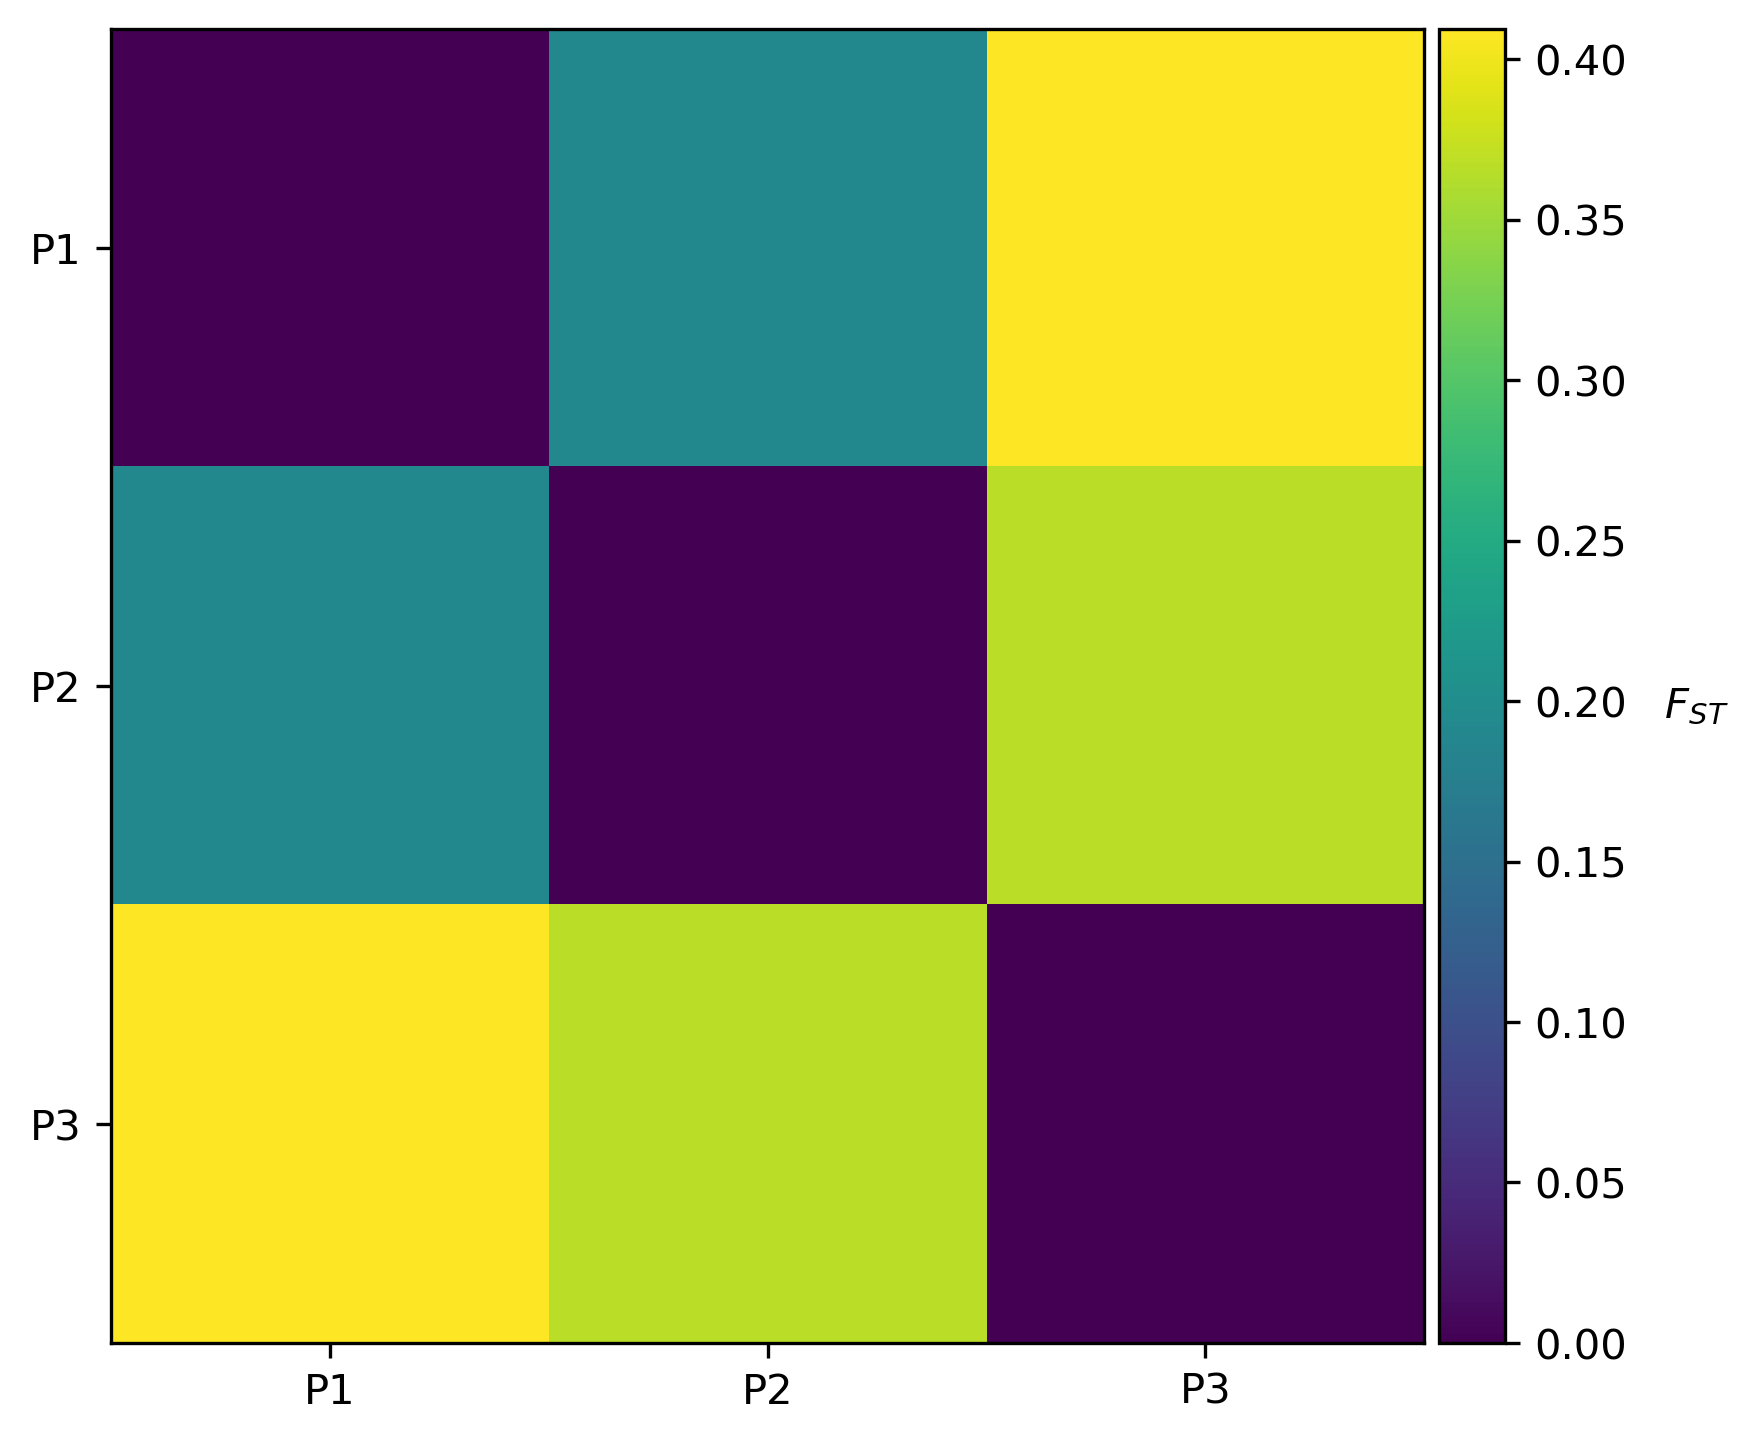

In [18]:
# Intialize the figure.
fig = plt.figure(figsize=(5, 5), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot pairwise Fst estimates.
im = ax.imshow(fst_mat)
# Intialize the positions for the colobar.
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
# Plot the color bar.
cbar = fig.colorbar(im, cax=cax)
# Set and label the y-axis ticks.
ax.set_yticks(
    np.arange(3), 
    labels=['P1', 'P2', 'P3'],
)
# Set and label the x-axis ticks.
ax.set_xticks(
    np.arange(3),
    labels=['P1', 'P2', 'P3'],
)
# Annotate the colobar.
cbar.set_label(r'        $F_{ST}$', rotation=0)
# Show the plot!
plt.show()

Were you correct? Now, before we plot what should we expect $d_{XY}$ to be between P1 and P3 relative to P2 and P3? Why? In general how will our $d_{XY}$ plot differ from the $F_{ST}$ plot (__HINT:__ think about the diagnol)? If you are lost please ask your instructor otherwise go ahead and plot!

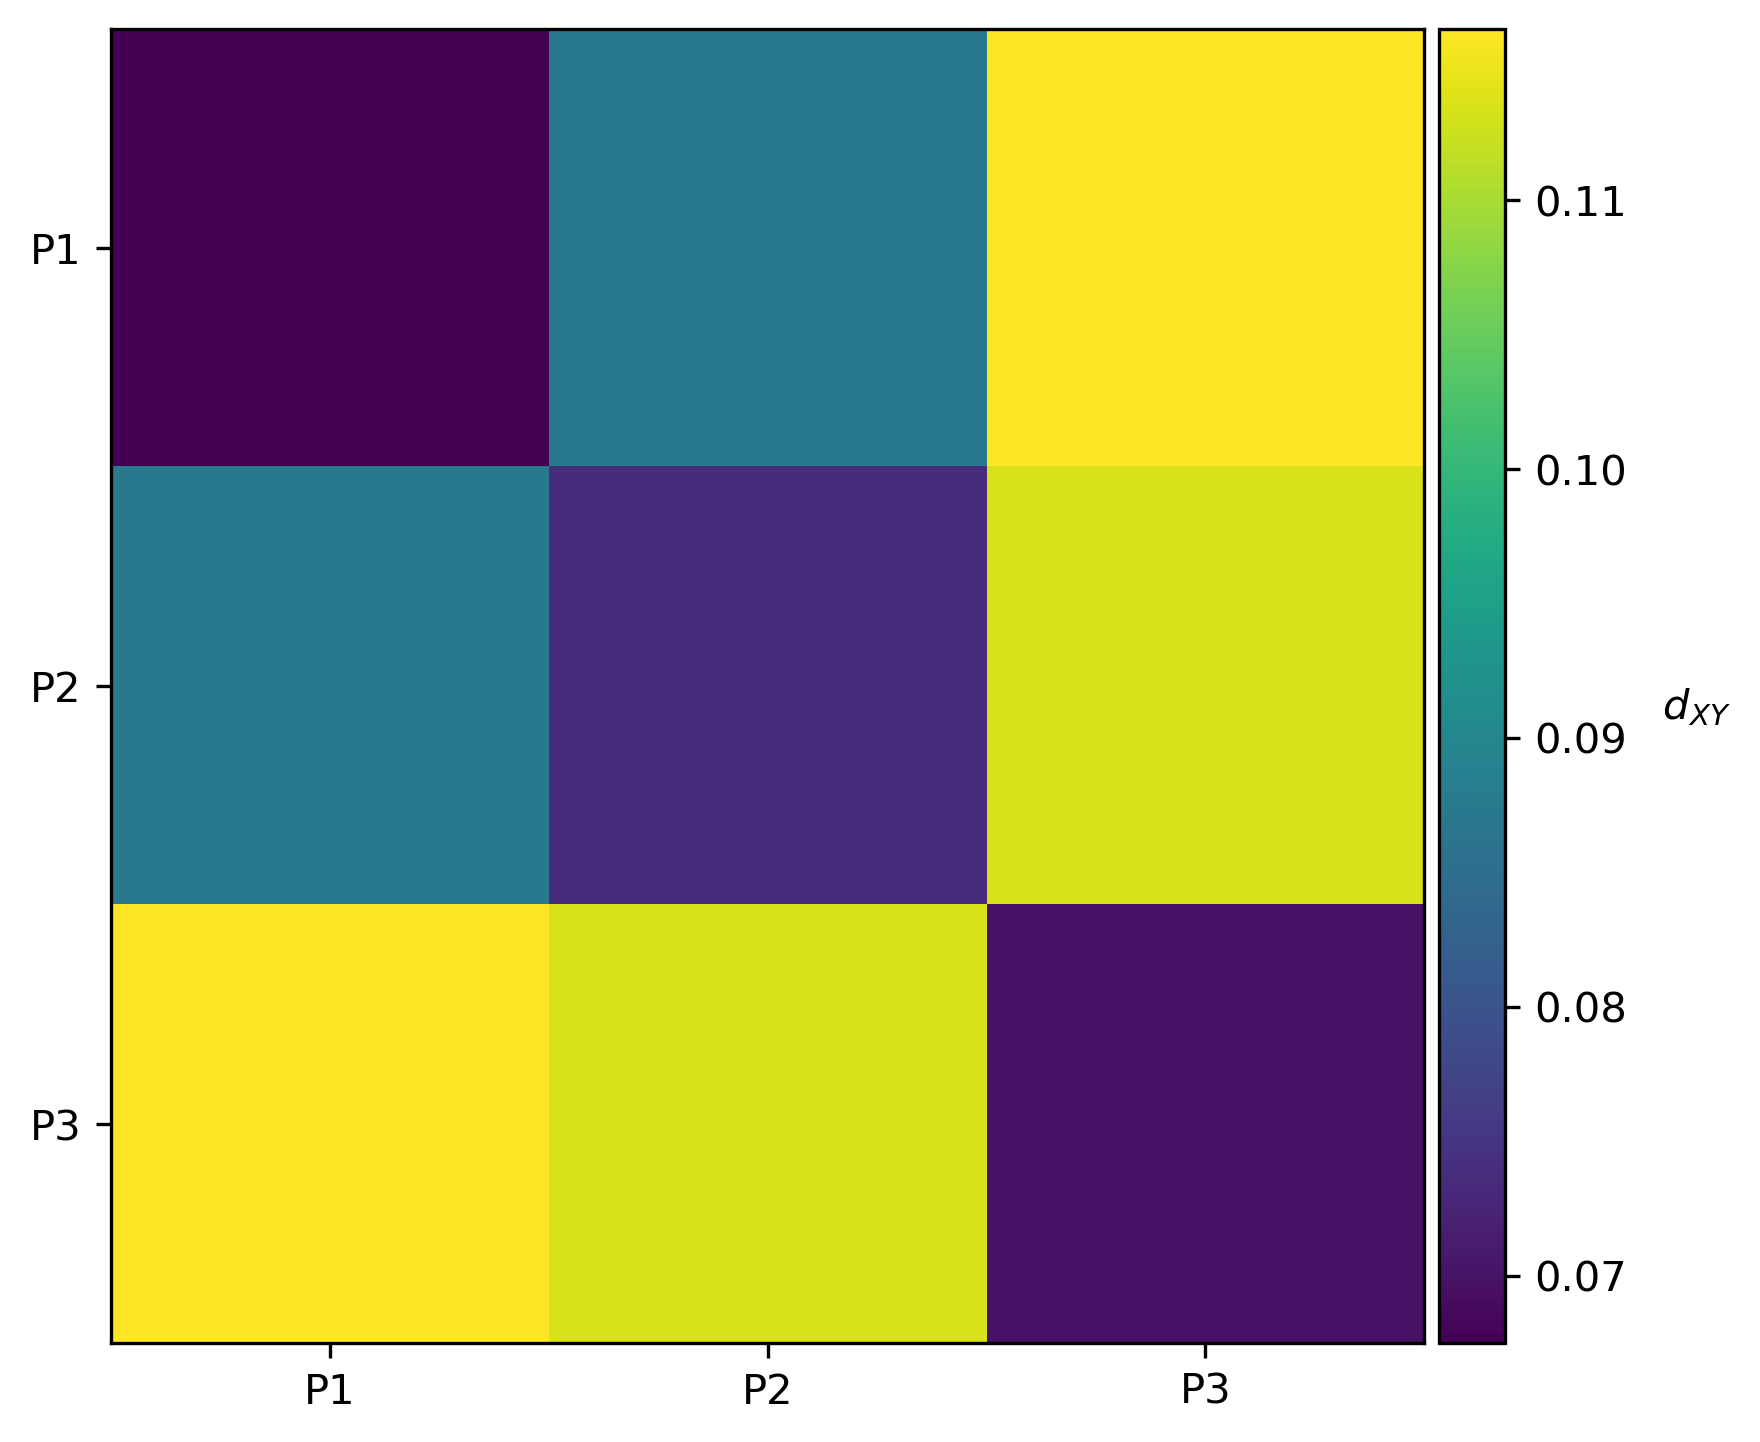

In [19]:
# Intialize the figure.
fig = plt.figure(figsize=(5, 5), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot pairwise Fst estimates.
im = ax.imshow(dxy_mat)
# Intialize the positions for the colobar.
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
# Plot the color bar.
cbar = fig.colorbar(im, cax=cax)
# Set and label the y-axis ticks.
ax.set_yticks(
    np.arange(3), 
    labels=['P1', 'P2', 'P3'],
)
# Set and label the x-axis ticks.
ax.set_xticks(
    np.arange(3),
    labels=['P1', 'P2', 'P3'],
)
# Annotate the colobar.
cbar.set_label(r'        $d_{XY}$', rotation=0)
# Show the plot!
plt.show()

What do you notice about the diagnol on the $d_{XY}$ plot? Where is it the highest and why? Confer with your partner and if you are confused please ask your instructor! 

## Challenge: Validating Patterson's D Derivation from Lecture

In lecture we derived the expectation for Patterson's D, but how do we know if our derivation is correct? If you said validating it with simulations then you are absolutely correct! For each admixture $f \in \{0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1\}$ validate that the expected value of Patterson's D closely matches the average from 1,000 replicate simulations. Show your results in table and the plot them!

In [20]:
# Define a function to compute the expectated number of ABBA site patterns.
def e_abba(
    f,
    mu=1.5 * 10**-8,
    seq_len=1_000_000,
    N=10_000,
    Tgf=1_000,
    Tp2=5_000,
    Tp3=15_000,
):
    """
    ###########################################################################
    INPUT
        Tp3: Divergence time between P12 and P3.
        Tp2: Divergence time between P1 and P2.
        Tgf: Time of gene flow (introgression) from P3 -> P2.
        N: Constant and equal effective population size.
        f: Admixture proportion.
        mu: Mutation rate.
        seq_len: Sequence length.
    ---------------------------------------------------------------------------
    OUTPUT: Expected number of ABBA site patterns.
    ###########################################################################
    """
    e_abba = (
        ((1 - f) * (((2*N)/float(3)) * ((1 - (1/float(2*N)))**(Tp3 - Tp2))))\
        + (f * ((((2*N)/float(3)) * ((1 - (1/float(2*N)))**(Tp3 - Tgf))) + (Tp3 - Tgf)))\
    )
    return e_abba * seq_len * mu
# Define a function to compute the expectated number of BABA site patterns.
def e_baba(
    f,
    mu=1.5 * 10**-8,
    seq_len=1_000_000,
    N=10_000,
    Tgf=1_000,
    Tp2=5_000,
    Tp3=15_000,
):
    """
    ###########################################################################
    INPUT
        Tp3: Divergence time between P12 and P3.
        Tp2: Divergence time between P1 and P2.
        Tgf: Time of gene flow (introgression) from P3 -> P2.
        N: Constant and equal effective population size.
        f: Admixture proportion.
        mu: Mutation rate.
        seq_len: Sequence length.
    ---------------------------------------------------------------------------
    OUTPUT: Expected number of BABA site patterns.
    ###########################################################################
    """
    e_baba = (
        ((1 - f) * (((2*N)/float(3)) * ((1 - (1/float(2*N)))**(Tp3 - Tp2))))\
        + (f * ((((2*N)/float(3)) * ((1 - (1/float(2*N)))**(Tp3 - Tgf)))))\
    )
    return e_baba * seq_len * mu
# Define a function to calculate the Patterson's D expected value.
def e_d(
    f,
    mu=1.5 * 10**-8,
    seq_len=1_000_000,
    N=10_000,
    Tgf=1_000,
    Tp2=5_000,
    Tp3=15_000,
):
    """
    ###########################################################################
    INPUT
        Tp3: Divergence time between P12 and P3.
        Tp2: Divergence time between P1 and P2.
        Tgf: Time of gene flow (introgression) from P3 -> P2.
        N: Constant and equal effective population size.
        f: Admixture proportion.
        mu: Mutation rate.
        seq_len: Sequence length.
    ---------------------------------------------------------------------------
    OUTPUT: Expectation of D.
    ###########################################################################
    """
    exp_abba = e_abba(
        f=f,
        mu=mu,
        seq_len=seq_len,
        N=N,
        Tgf=Tgf,
        Tp2=Tp2,
        Tp3=Tp3,
    )
    exp_baba = e_baba(
        f=f,
        mu=mu,
        seq_len=seq_len,
        N=N,
        Tgf=Tgf,
        Tp2=Tp2,
        Tp3=Tp3,
    )
    d = (exp_abba - exp_baba) / (exp_abba + exp_baba)
    return d

In [32]:
# Intialize the admixture proportions.
fs = np.array([
    0, 0.1, 0.2, 0.3,
    0.4, 0.5, 0.6,
    0.7, 0.8, 0.9, 1
])
# Intialize a list to store simulated results.
sim_d = []
# For 1000 simulated replicates.
for f in fs:
    # Intialize a list for this admixture proportion.
    f_list = []
    # For 100 replicates...
    for _ in range(100):
        # Intialize a list to store loci.
        loci = []
        # For 100 indepedent loci...
        for _ in range(100):
            ts = msprime.sim_ancestry(
                samples=[
                    msprime.SampleSet(1, ploidy=1, population='P1'),
                    msprime.SampleSet(1, ploidy=1, population='P2'),
                    msprime.SampleSet(1, ploidy=1, population='P3'),
                    ],
                demography=iua(f=f),
                sequence_length=10_000,
                recombination_rate=10**-8,
            )
            # Overlay mutations on the tree-sequence.
            mts = msprime.sim_mutations(
                tree_sequence=ts,
                rate=1.5 * 10**-8,
                discrete_genome=False,
            )
            # Append the locus.
            loci.append(mts.genotype_matrix())
        # Concatenate the loci.
        genome = np.vstack(loci)
        # Compute Patterson's D.
        _, _, d_val = pattersons_d(
            genotype_matrix=genome,
            p1_idx=[0],
            p2_idx=[1],
            p3_idx=[2],
        )
        # Append the results.
        f_list.append(d_val)
    # Update the simulated mean list.
    sim_d.append(np.nanmean(np.array(f_list)))

In [33]:
# Calculate the analystical results.
exp_d = e_d(f=np.linspace(0, 1, 100))

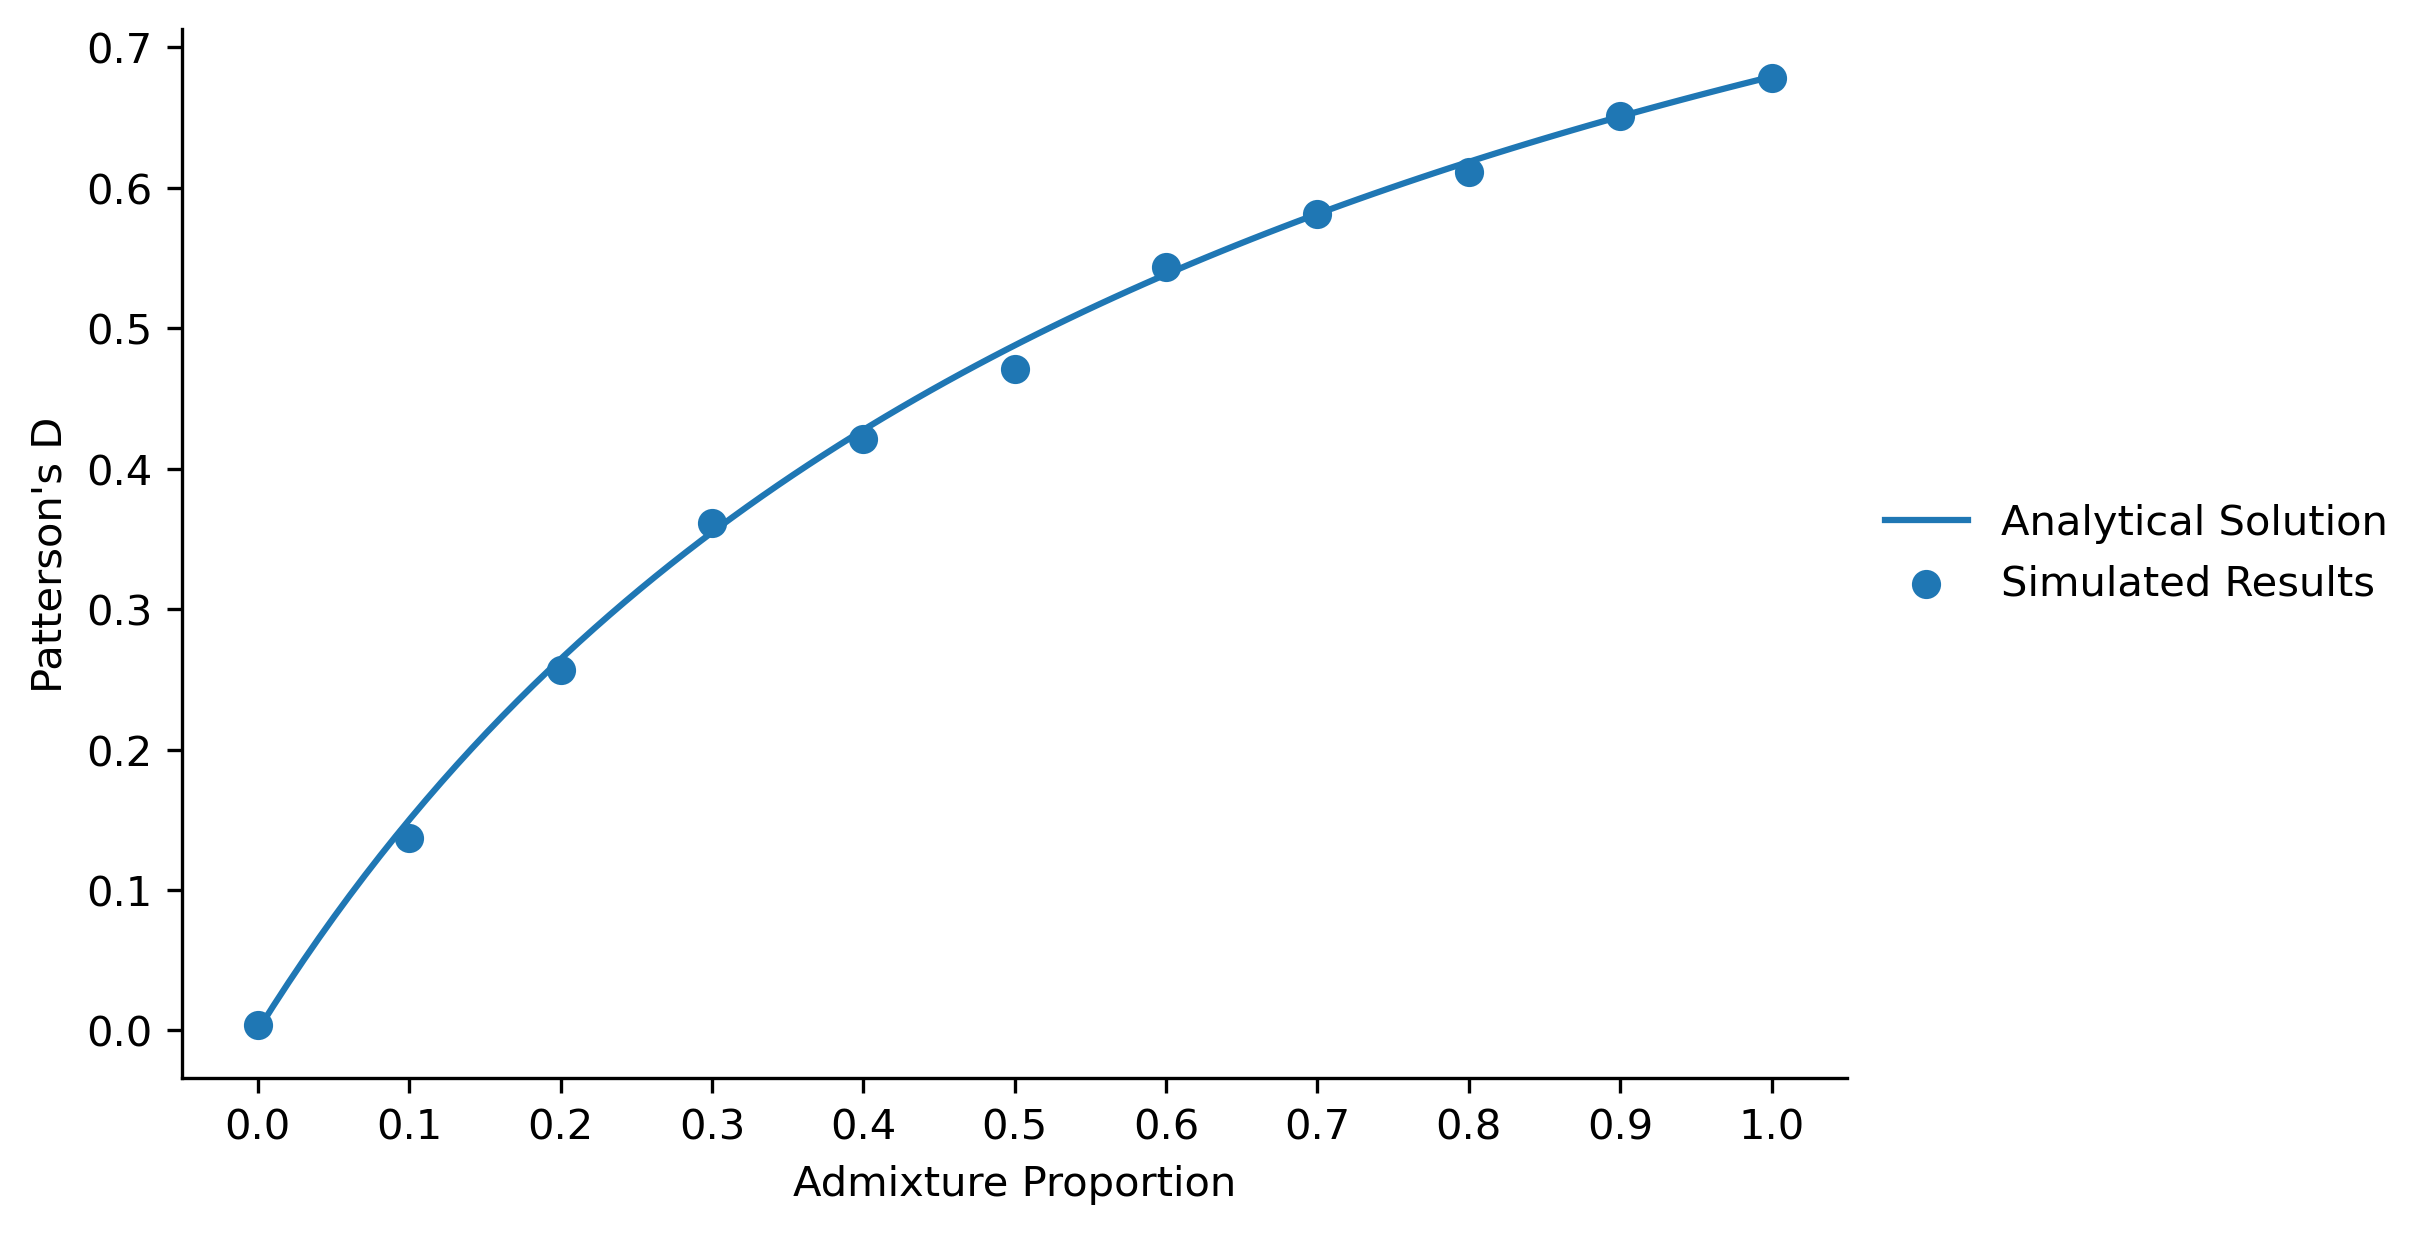

In [34]:
# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the analytical values.
ax.plot(
    np.linspace(0, 1, 100), exp_d,
    label='Analytical Solution',
)
# Plot the simulated means.
ax.scatter(
    fs, sim_d,
    label='Simulated Results',
)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Label the x-axis ticks.
ax.set_xticks(fs)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('Admixture Proportion')
plt.ylabel('Patterson\'s D')
# Show!
plt.show()